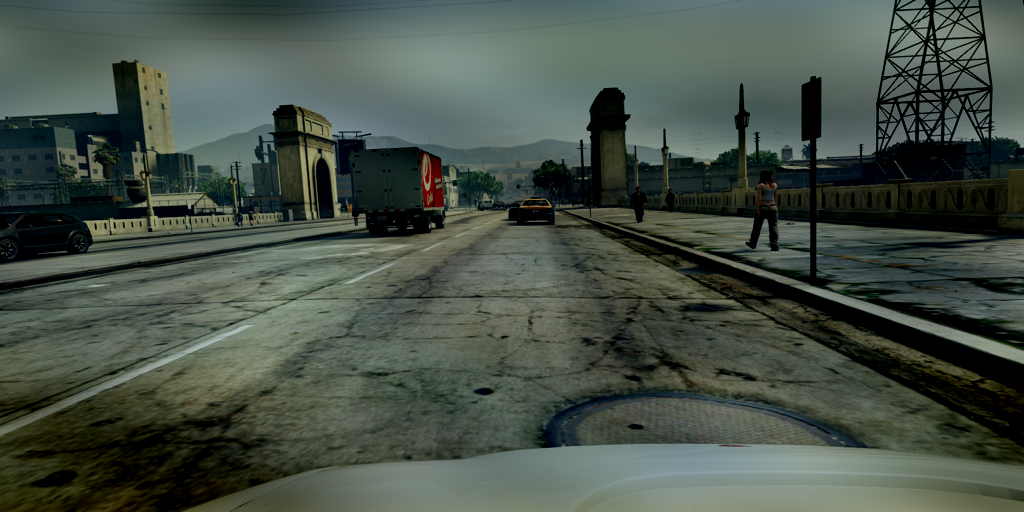

In [3]:
import numpy as np
from PIL import Image
from IPython.display import display

def FDA_source_to_target_np(source_array, target_array, L=0.01):
    # Compute the FFT of both source and target images
    fft_source = np.fft.fft2(source_array, axes=(-2, -1))
    fft_target = np.fft.fft2(target_array, axes=(-2, -1))

    # Extract amplitude and phase of both FFTs
    amplitude_source, phase_source = np.abs(fft_source), np.angle(fft_source)
    amplitude_target, phase_target = np.abs(fft_target), np.angle(fft_target)

    # Apply amplitude mutation between source and target
    amplitude_source_modified = low_freq_mutate_np(amplitude_source, amplitude_target, L=L)

    # Reconstruct the source image with modified amplitude and original phase
    fft_source_modified = amplitude_source_modified * np.exp(1j * phase_source)
    adapted_source = np.fft.ifft2(fft_source_modified, axes=(-2, -1))
    adapted_source = np.real(adapted_source)

    return adapted_source

def low_freq_mutate_np(amp_src, amp_trg, L=0.1):
    # Shift the amplitude spectra to center low frequencies
    a_src = np.fft.fftshift(amp_src, axes=(-2, -1))
    a_trg = np.fft.fftshift(amp_trg, axes=(-2, -1))

    _, h, w = a_src.shape
    b = int(np.floor(np.amin((h, w)) * L))  # width of the square frequency band at the center
    center_h = int(np.floor(h / 2))
    center_w = int(np.floor(w / 2))

    h1, h2 = center_h - b, center_h + b + 1
    w1, w2 = center_w - b, center_w + b + 1

    # Replace the low-frequency components of the source with those from the target
    a_src[:, h1:h2, w1:w2] = a_trg[:, h1:h2, w1:w2]
    a_src = np.fft.ifftshift(a_src, axes=(-2, -1))

    return a_src

# Load source and target images and convert to RGB
source_image = Image.open("../../TEST IMAGES/source.png").convert('RGB')
target_image = Image.open("../../TEST IMAGES/target.png").convert('RGB')

# Resize images to ensure they have the same dimensions
resize_dimensions = (1024, 512)
source_image_resized = source_image.resize(resize_dimensions, Image.BICUBIC)
target_image_resized = target_image.resize(resize_dimensions, Image.BICUBIC)

# Convert images to numpy arrays of type float32 for processing
source_array = np.array(source_image_resized, dtype=np.float32)
target_array = np.array(target_image_resized, dtype=np.float32)

# Rearrange array dimensions to (channels, height, width) for FFT processing
source_array = source_array.transpose((2, 0, 1))
target_array = target_array.transpose((2, 0, 1))

# Apply Frequency Domain Adaptation
adapted_source_array = FDA_source_to_target_np(source_array, target_array, L=0.01)

# Revert dimensions to (height, width, channels) for image saving
adapted_source_array = adapted_source_array.transpose((1, 2, 0))
adapted_source_array = np.clip(adapted_source_array, 0, 255)  # Ensure the pixel values are within the [0, 255] range

# Convert adapted array back to image and save it
output_image = Image.fromarray(adapted_source_array.astype('uint8'))
output_image.save('adapted_source_in_target.png')
display(output_image)